# Optimization lecture 14: L1-regularized reconstruction

In [2]:
## MP 573 Part 2, Lecture 14: L1-regularized reconstruction
##
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
from scipy import signal
import scipy.io as sio
import scipy.optimize as opt
import numpy.random as rnd
import numpy.matlib as matlib
import scipy.sparse as sparse
import skimage.data as skdata
import skimage.transform as transform

font = {'weight' : 'normal',
        'size'   : 16}

In [3]:
# Fitting || Fx - d ||^2 + lambda ||Dx||
# This function returns the value of our cost function
def evalFun_L1(x,N,data,m,lam,D,mu):
    
    N1 = N[0]
    N2 = N[1]
    
    wvec = np.reshape(w,(N1*N2,1))
    
    fx1 = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(np.reshape(x,(N1,N2)))))

    fx1 = np.reshape(fx1,(N1*N2,1))
    fx = fx1[np.reshape(m,(N1*N2))]
    
    Dx = D.dot(np.reshape(x,(N1*N2,1)))
    l1term = np.sqrt(np.abs(Dx)**2 + mu);
    
    f = la.norm(fx-data)**2 + lam*np.sum(l1term)
            
    return f


In [4]:
# Fitting || Fx - d ||^2 + lambda ||Dx||
# This function returns the value and gradient of our cost function
def evalGradients_L1(x,N,data,m,lam,D,mu):
    
    N1 = N[0]
    N2 = N[1]
    
    wvec = np.reshape(w,(N1*N2,1))
    
    fx1 = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(np.reshape(x,(N1,N2)))))

    fx1 = np.reshape(fx1,(N1*N2,1))
    fx = fx1[np.reshape(m,(N1*N2))]
    
    Dx = D.dot(np.reshape(x,(N1*N2,1)))
    l1term = np.sqrt(np.abs(Dx)**2 + mu);
    
    f = la.norm(fx-data)**2 + lam*np.sum(l1term)
    
    fhfx = N1*N2*np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(np.reshape(m,(N1,N2))*np.reshape(fx1,(N1,N2)))))
    mhd = np.zeros((N1*N2,1),dtype='complex')
    mhd[np.reshape(m,(N1*N2))] = data    
    fhd = N1*N2*np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(np.reshape(mhd,(N1,N2)))))
    g1 = 2*np.reshape(fhfx,(N1*N2,1)) - 2*np.reshape(fhd,(N1*N2,1))
    temp = (D.dot(np.reshape(x,(N1*N2,1))))
    g2 =  lam*(D.T).dot(Dx/l1term)
    g = g1 + g2
            
    return f,g



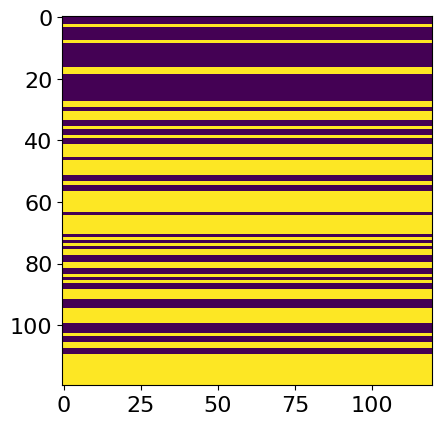

In [ ]:
#Here's the data
xtrue = skdata.shepp_logan_phantom()
xtrue = transform.rescale(xtrue, scale=0.3)
N1,N2 = xtrue.shape
data = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(xtrue)))

# Create subsampling mask
mask1 = np.random.uniform(0,1,(N1)) > 0.53  #0.53 originally
mask1[int(np.round(N1*30/70)):int(np.round(N1*40/70))]=True # 30/70 to 40/70 originally
m = matlib.repmat(np.reshape(mask1,(N1,1)),1,N2);

# Undersample data
data = data[mask1,:]
M1,M2 = data.shape
datavec = np.reshape(data,(M1*M2,1))


w = np.ones((N1,N2))    
lam = 10

niter = 500 # Number of overall descent iterations
niterGS = 30 # Number of golden section search iterations within each SD iteration

wvec = np.reshape(w,(N1*N2,1))

# Here's a finite-difference taking matrix
I = np.eye(N1)
#D = 2*I - np.roll(I,-1,axis=1) - np.roll(I,1,axis=1)
D = I - np.roll(I,-1,axis=1)
D = sparse.csr_matrix(D) 
I = sparse.eye(N1)
D2 = sparse.kron(D,I) + sparse.kron(I,D)

plt.imshow(m);


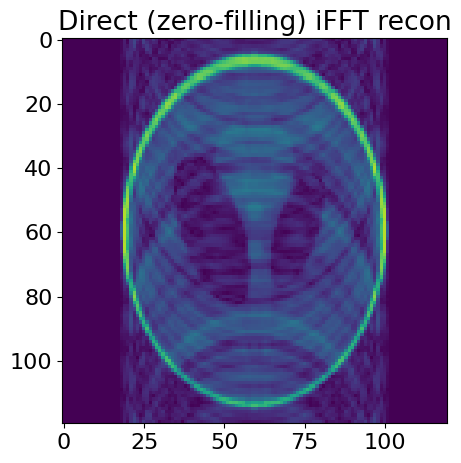

In [9]:
# Zero-filled solution
fx1 = np.zeros((N1*N2,1),dtype='complex') 
fx1[np.reshape(m,(N1*N2))] = datavec
fx1 = np.reshape(fx1,(N1,N2))
x1 = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(fx1)))

plt.figure(figsize=(5,5))
imgplot = plt.imshow(abs(np.reshape(x1,(N1,N2))),vmin=0,vmax=1)
plt.title('Direct (zero-filling) iFFT recon');
plt.rc('font', **font)

Algorithm: Conjugate Gradients
Iter: 50, f = 7589.314524494986
Iter: 100, f = 6781.206470703117
Iter: 150, f = 6400.002921174856
Iter: 200, f = 6211.714722847615
Iter: 250, f = 6114.941572114469
Iter: 300, f = 6073.121825018029
Iter: 350, f = 6055.25039099898
Iter: 400, f = 6046.4963175394005
Iter: 450, f = 6041.432720665279
Done, cost function = 
6038.4822186581905


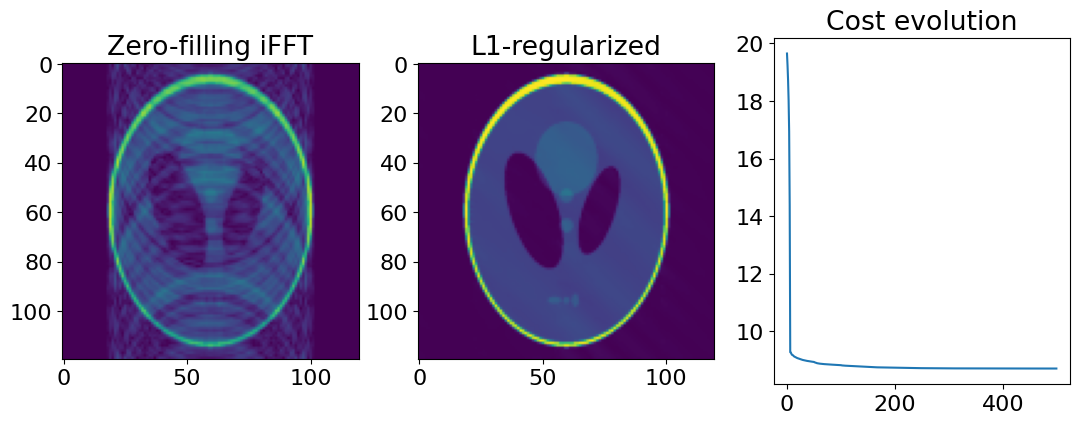

In [ ]:
print('Algorithm: Conjugate Gradients')
INIT_ZEROFILLED = 1
if INIT_ZEROFILLED>0:
    x = x1
else:
    x = 0*x1
    
#x = xtrue    
mu = 1E-6
    
x = np.reshape(x,(N1*N2,1))
    
allfCG = np.zeros(niter)

f,g = evalGradients_L1(x,[N1,N2],datavec,m,lam,D2,mu)
restart_d = False

allfCG[0] = f 
if la.norm(g)>0.000001:
    d = -g
    k=1;
    while k < niter:
        dnorm = d/np.max(abs(d))
        a0 = 0
        b0 = 1
        for kg in range(0,niterGS): # Golden section search within each iteration
            a1 = x + dnorm*a0 + dnorm*(b0-a0)*0.382;
            b1 = x + dnorm*a0 + dnorm*(b0-a0)*0.618;
            fa1 = evalFun_L1(a1,[N1,N2],datavec,m,lam,D2,mu)
            fb1 = evalFun_L1(b1,[N1,N2],datavec,m,lam,D2,mu)
            if fb1<fa1:
                a0 = a0 + 0.382*(b0-a0);
            else:
                b0 = a0 + 0.618*(b0-a0);
            if b0-a0<1E-5:
                kg=niterGS
            
            
        alpha = (a0+b0)/2;
        fnew = evalFun_L1(x +alpha*dnorm,[N1,N2],datavec,m,lam,D2,mu)
        if fnew < f:
            x = x +alpha*dnorm;
            restart_d = False
        else:
            restart_d = True
        
        gprevious = g
        fprevious = f
        f,g = evalGradients_L1(x,[N1,N2],datavec,m,lam,D2,mu)
        
        allfCG[k] = f
        
        if la.norm(g)>0.000001:
            if (k%50>0) and (restart_d == False):
                #b = (np.conj(g.T).dot(g))/(np.conj(gprevious.T).dot(gprevious));               
                b = (la.norm(g)**2)/(la.norm(gprevious)**2)
                d = -g + b*d;
            else:
                d = -g;
        
            if k%50 == 0:
                print('Iter: ' + str(k) + ', f = ' + str(f))
        
        else:
            k=niter
        k = k+1

# Collect output and display results        
xCG = np.reshape(x,(N1,N2))        
print('Done, cost function = ')
print(f)

      
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4.5))
plt.rc('font', **font)
ax1.set_title("Zero-filling iFFT")
ax1.imshow(abs(np.reshape(x1,(N1,N2))), vmin=0, vmax=1)
ax2.set_title("L1-regularized")
ax2.imshow(abs(xCG), vmin=0, vmax=1)
ax3.set_title("Cost evolution")
ax3.plot(np.log(allfCG));
